In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Define feature groups for preprocessing

In [2]:
numerical_cols=['tenure','MonthlyCharges','TotalCharges']
one_hot_cols=['PaymentMethod','InternetService','MultipleLines']
ordinal_cols=['gender','SeniorCitizen','Partner','Dependents','PhoneService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Contract',]

In [3]:
df = pd.read_csv('csvs/churn.csv')

# Filter TotalCharges so it can be used in the model and standardize 'No internet service' to 'No' for consistency

In [4]:
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[col]=df[col].replace('No internet service', 'No')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges']=df['TotalCharges'].fillna(0)

# Encode target variable (Churn) to binary

In [5]:
X= df[numerical_cols+one_hot_cols+ordinal_cols]
y=df['Churn'].map({'Yes':1,'No':0})

In [6]:
X_train,X_valid,y_train,y_valid=train_test_split(X,y,random_state=1,stratify=y)

In [7]:
imputer = SimpleImputer()

# Made the pipelines with unkown value handling

In [8]:
hot_transformer=Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                ('hot_encoder',OneHotEncoder(handle_unknown='ignore'))])

In [9]:
ordinal_transformer=Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                ('ordinal_encoder',OrdinalEncoder(unknown_value=-1,handle_unknown='use_encoded_value'))])

In [10]:
preprocessor = ColumnTransformer([('imputer', imputer,numerical_cols), ('hot_encoder',hot_transformer,one_hot_cols),('ordinal_encoder',ordinal_transformer,ordinal_cols)])

In [11]:
X_train=preprocessor.fit_transform(X_train)
X_valid=preprocessor.transform(X_valid)

# Use early_stopping_rounds to avoid overfitting

In [12]:
model = XGBClassifier(n_jobs=-1,random_state=1,n_estimators=2000, early_stopping_rounds=50,max_depth=5, learning_rate=0.05)

In [13]:
model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)],verbose=False)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [14]:
probabilities = model.predict_proba(X_valid)

# Get only the probability of churn

In [15]:
probabilities=probabilities[:,1]

In [16]:
print(roc_auc_score(y_valid,probabilities))

0.84349195264588


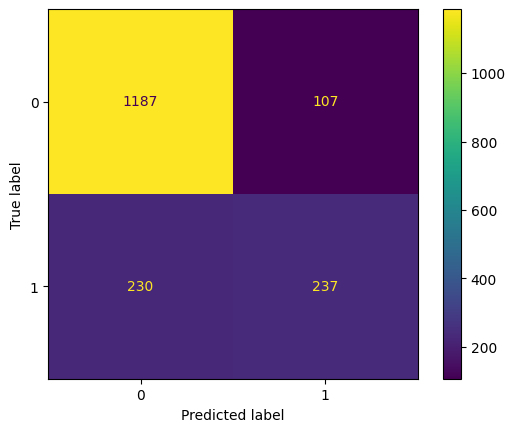

In [17]:
ConfusionMatrixDisplay.from_estimator(
    model, 
    X_valid, 
    y_valid)